## **Future analysis of agricultural land fertility in Europe and Asia.**
## Rice yield and production forecast.

## Import libraries and modules 

This section includes import of
* Python libraries
* modules available in the repository

In [1]:
import pickle
import pandas as pd
import json
import numpy as np

import sys, os
sys.path.append('../src/')
import load_data, utils

sys.path.append('../src/models/')
import fert_regression, yield_regression

## Data source 

All the data used in research was obtained with Gogle Earth Engine.

Nevertheless, to simplify the access we loaded all data to [Google Drive folder](https://drive.google.com/drive/folders/1reYmmjR6ckznwakdeLyAC6DVKp3Adp2y?usp=sharing). Below this folder is refered to as `path`.

In [8]:
# Set the path do data folders
path =  '/Geo_data/'
path_econ = os.path.join(path, 'Crop_Eurasia/Economics', '')

if not os.path.exists(path_econ):
    os.makedirs(path_econ)

path_faostat = os.path.join(path, 'FAOSTAT', '')

# FAOSTAT file names
data_production = 'product_v7.csv'
data_area_arable = 'area_sums_v3.csv'
data_area_crops = 'area_v10.csv'
data_fertilizers = 'fert_v5.csv'

# Data from climate model
crop_changes = 'crops_disappear_2019_2026.txt'

Next, we define the list of countries, climate variables, crops

In [3]:
country_names = ['Japan', 'Kazakhstan', 
                'Myanmar', 'Philippines',
                'Korea', 'Turkey', 
                'Thailand', 'Uzbekistan', 
                'Viet Nam']

prefixes = ['JPN', 'KAZ', 
            'MMR', 'PHL',
            'KOR', 'TUR',
            'THA', 'UZB', 
            'VNM']

# Climate variables
vars  = ['pr','tmmx','tmmn']

# Crop variables
crops = ['Wheat', 'Maize', 'Soya', 'Rice']

# Fertilizer variables
fert = ['N', 'P2O5', 'K2O']

# Count countries
n_count = len(prefixes)

# Count months
n_months = 12

# Count features
n_feat = len(vars) * 2 * n_months + n_count*2 + len(crops)+ len(fert)

#### Set dates

Here the user specifies the desired years for the analysis. If the data was taken from Google Drive linked above, please pay attention on years ranges available (listed in [README file](https://github.com/DariaTan/ArableLand2/blob/main/README.md)).

In [4]:
# Historical period
years = np.arange(1995, 2020)

# Future period
years_future = np.arange(2026, 2027)

Climate dataset is collected withing country borders and includes means of precipitation, maximum and minimum temperatures distribution in each month along with their variances. I could be either historical (TerraClimate) or future (CMIP5) data.

In [9]:
Climate = load_data.climate_for_yield(path, prefixes, country_names, vars, years, years_future, n_months)

FAOSTAT data gives the total area of arable lands of every country and its consumpion of fertilizers. Here we will divide one by another to get the fertilizers consumption per unit area. 

In [10]:
# Crop area
Total_area = load_data.arable_area(path_faostat, data_area_arable, data_area_crops, prefixes, country_names, years, crops)

# Fertilizers data
Fert = load_data.fertilizers(path_faostat, data_fertilizers, prefixes, country_names, years)

Since we've obtained prediction related to change in arable lands for each country, here we load the dictionary with that numbers.

In [16]:
# Load expected negative crop changes from climate_lc model
with open('crops_disappear_2019_2026.pickle', 'rb') as handle:
    neg_trend = pickle.load(handle)

## Fertilizers model

Here we run regression model to make a forecast on fertilizers consumpion, as it influences the yield. The prediction is created separately for each country.

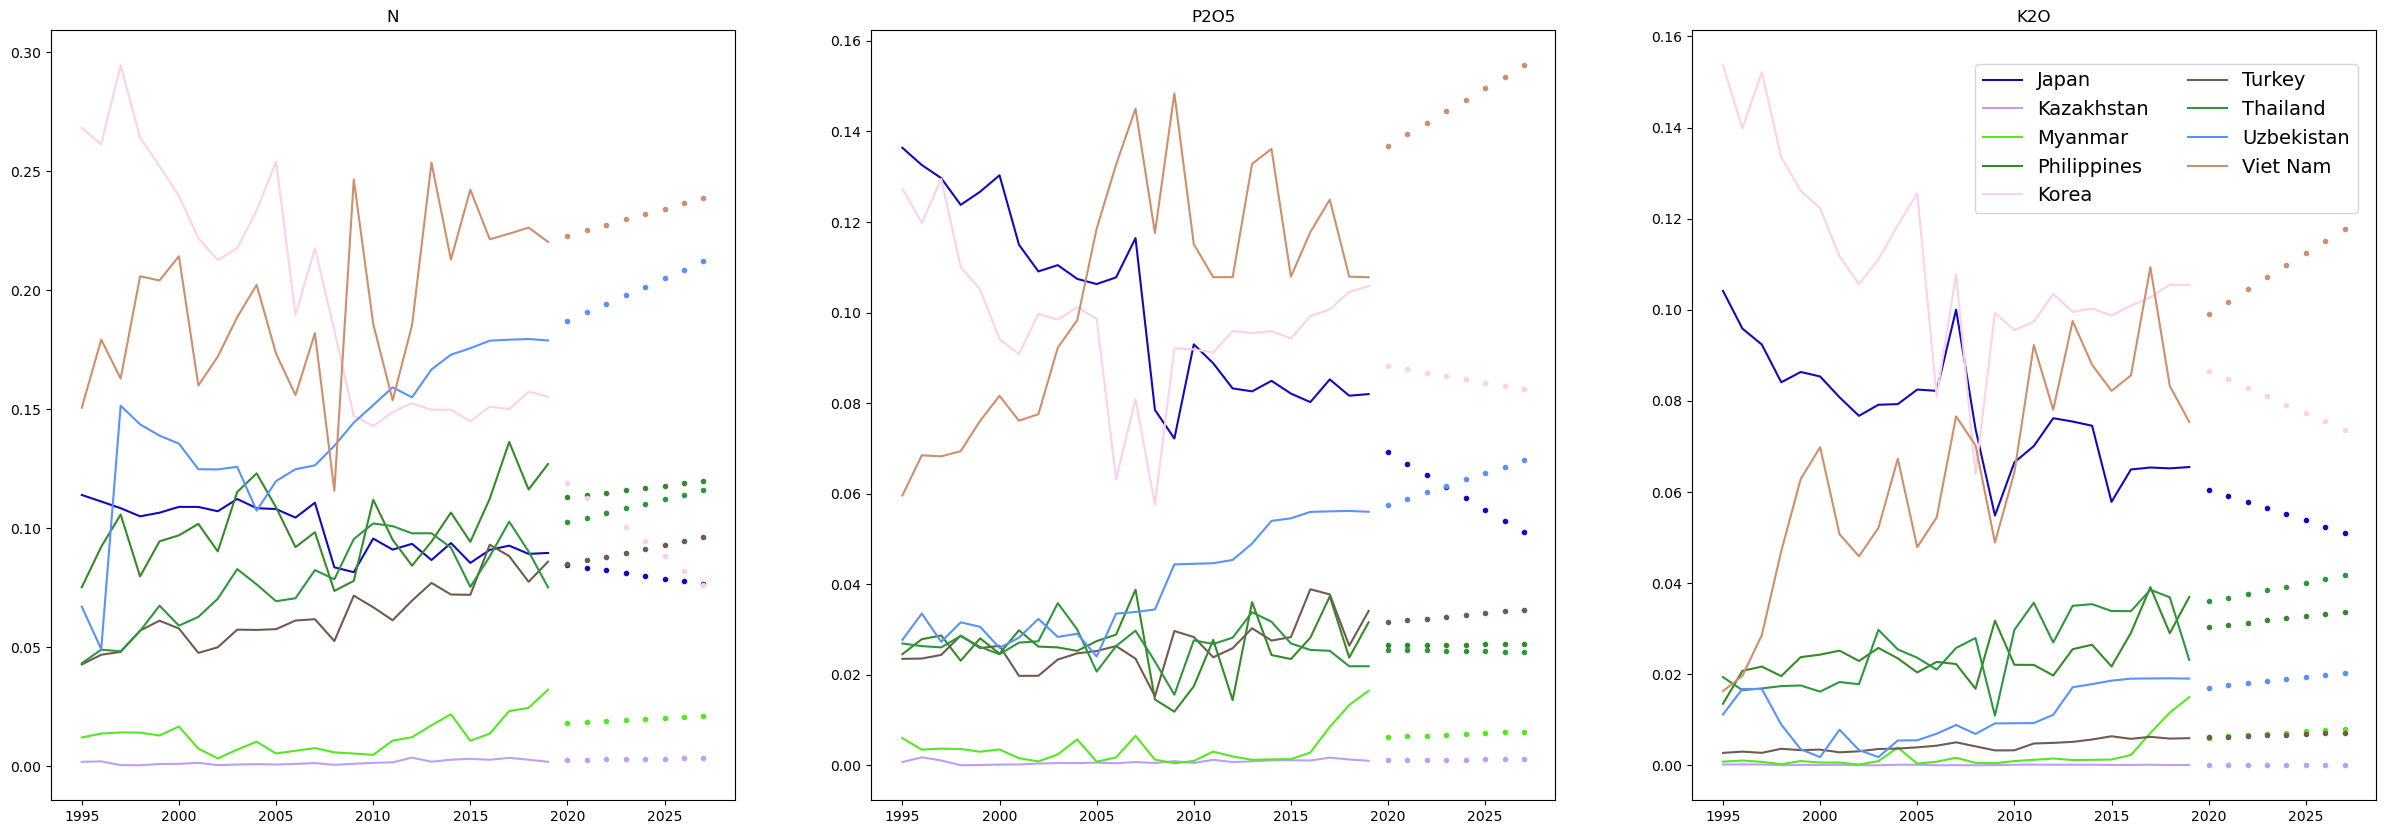

In [17]:
years_future_fert = np.arange(2020, 2028)
Fert_future = fert_regression.model(Fert, Total_area,
                                    prefixes, country_names,
                                    years, years_future_fert)

## Rice yield model

Before fitting the yield model we applied rolling mean to all historical data. In general it smoothes it a bit and improves the overall prediction.

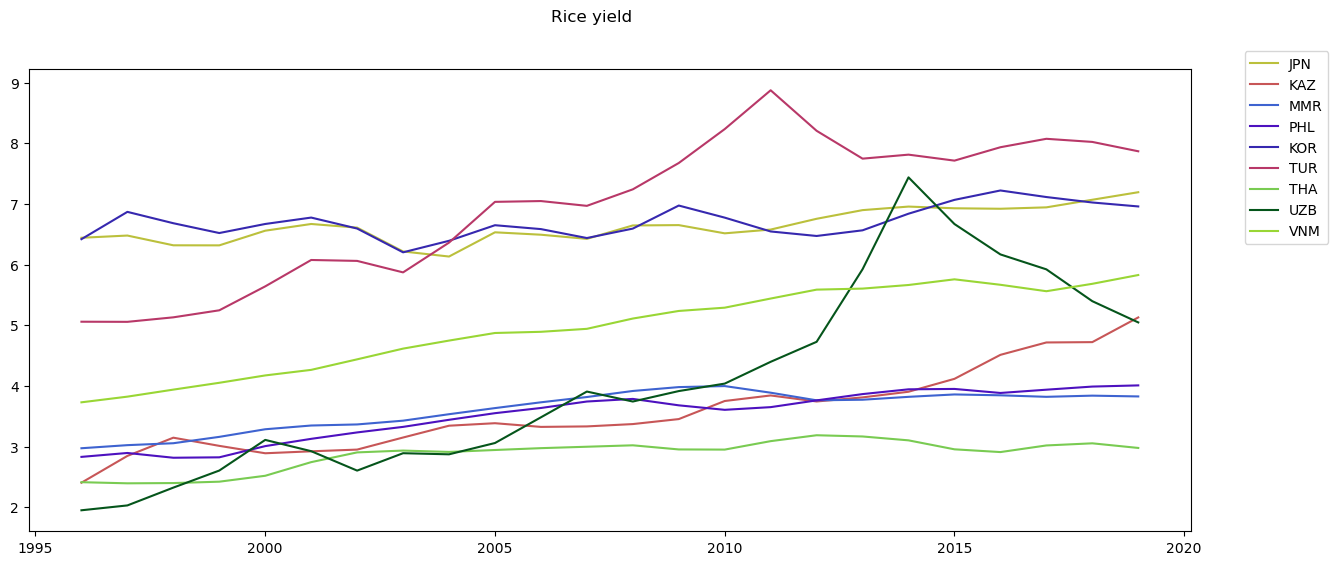

In [18]:
# Apply rolling mean to yield data
Yield = utils.yield_rolling_mean(path_faostat, data_production, 
                       prefixes, country_names, 
                       Total_area, years, window = 2)

With all data avilable it is time to collect train and test sets for all crops and extract samples with rice only for our task.

In [19]:
# Collect data for train and test
X_train, Y_train, X_test, Y_test = utils.collect_data_yield(path_faostat, data_production, 
                                                            prefixes, country_names, 
                                                            Climate, Fert, Yield, 
                                                            Total_area, crops, vars, 
                                                            years, n_feat)

# Find data with rice as a crop
X_train_rice = X_train[X_train[:,-1]==1][:,:-4]
Y_train_rice = Y_train[X_train[:,-1]==1][:,0].astype(float)
X_test_rice = X_test[X_test[:,-1]==1][:,:-4]
Y_test_rice = Y_test[X_test[:,-1]==1][:,0].astype(float)
print('Rice #samples', X_train_rice.shape)

Rice #samples (198, 93)


The similar procedure run for future data.

In [20]:
X_future = utils.collect_future_data(path_faostat, data_production,
                        prefixes, country_names,
                        Climate, Fert_future,
                        crops, vars,
                        years, years_future, n_feat)
X_future_rice = X_future[X_future[:,-1]==1][:,:-4]

For more informative representation we collect the feature names and show it like a dataframe for few first samples.

In [21]:
columns = []
for var in vars:
    for month in np.arange(1, n_months+1):
        columns.append(var + '_' + str(month))
        columns.append(var + '_' + str(month) + '_var')
for f in fert:
    columns.append(f)
for prefix in prefixes:
    columns.append('Trend_' + prefix)
for prefix in prefixes:
    columns.append(prefix)

df_f = pd.DataFrame(X_train_rice, columns = columns)
df_f.iloc[:5,:]

,pr_1,pr_1_var,pr_2,pr_2_var,pr_3,pr_3_var,pr_4,pr_4_var,pr_5,pr_5_var,...,Trend_VNM,JPN,KAZ,MMR,PHL,KOR,TUR,THA,UZB,VNM
0,4.842328,391.603333,3.924682,219.114761,9.909439,1289.429443,5.330798,488.361542,9.202442,1075.488647,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.445887,507.884308,3.901405,209.231903,6.649688,584.158569,9.026928,1219.824463,12.680779,2010.505005,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12.951782,2856.069336,7.675245,953.471680,6.453110,569.612244,13.037421,2636.716064,15.457264,3355.376709,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.361329,323.597748,5.385763,405.437286,9.281306,1144.234375,9.176821,1185.017822,11.244739,1658.841675,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.570578,848.969788,3.622989,210.496872,7.975270,817.030457,10.898942,1473.250610,9.892322,1359.153076,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Fitting the regression model for yield prediction.

In [22]:
from yield_regression import regression
xgbr =  regression()
xgbr.fit(X_train_rice, Y_train_rice)

# Calculate the scores
print('r2 on train data', xgbr.r2(X_train_rice, Y_train_rice))
print('r2 on test data', xgbr.r2(X_test_rice, Y_test_rice))

pred = xgbr.predict(X_test_rice)
print('MAPE on test data', xgbr.mape(pred, Y_test_rice))

r2 on train data 0.9999998853707417
r2 on test data 0.944170942653938
MAPE on test data 0.0567197461691252


Next table shows the evaluation of the model for several countries.

Area resuction comes from the crop model as was menioned before. historical yield and producion are taken from FAOSTAT, while their future yield is calculated with yield modeling and future producion is calculated based on it with the expected change in rice arable area. Here we assume for simplicity that any reduction in total arable lands entails the same reduction of area for every crop.

In [23]:
df = utils.yield_outcome(xgbr, Y_test, X_future_rice, 
                        Total_area, neg_trend,
                        prefixes)
df

,Country,Area_reduction,Yield_hist,Yield_future,Yield_ratio,Prod_hist,Prod_future,Prod_ratio
0,JPN,-10.4,7.07,6.92,-2.12,10390408,9114298,-12.3
1,KAZ,-16.4,4.72,4.5,-4.66,479142,381418,-20.4
2,MMR,-3.2,3.84,3.81,-0.78,27448532,26342436,-4.0
3,PHL,-7.4,3.99,3.79,-5.01,19148381,16855657,-12.0
4,KOR,-6.5,7.02,6.7,-4.56,5180825,4621989,-10.8
5,TUR,-9.7,8.02,7.28,-9.23,963691,789222,-18.1
6,THA,-1.9,3.05,2.62,-14.10,32513396,27364855,-15.8
7,UZB,-2.4,5.4,5.93,9.81,227417,243725,7.2
8,VNM,-11.9,5.68,5.36,-5.63,43022757,35730666,-16.9
